In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# 1. Load dataset
df = pd.read_csv("custom_sample_mass_radius_k2_5.csv")
X = df.drop(columns=["Type"]).values.astype(np.float32)
y = df["Type"].values

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, train_size=0.75, random_state=42)





In [19]:
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from skorch import NeuralNetClassifier

class FlexibleModel(nn.Module):
    def __init__(self, in_features, hidden_layers, out_features, dropout_p=0.3):
        """
        in_features: int — input features
        hidden_layers: list of ints — neurons in each hidden layer
        out_features: int — number of outputs (classes)
        dropout_p: float — dropout probability
        """
        super().__init__()
        layers = []
        prev = in_features
        for h in hidden_layers:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.ReLU())
            # layers.append(nn.Dropout(p=dropout_p))
            prev = h
        self.hidden = nn.Sequential(*layers)
        self.out = nn.Linear(prev, out_features)

    def forward(self, x):
        x = self.hidden(x)
        x = self.out(x)
        return x


X_train_ = X_train.astype(np.float32)
X_test_ = X_test.astype(np.float32)
y_train_ = y_train.astype(np.longlong)
y_test_ = y_test.astype(np.longlong)

input_dim = X_train_.shape[1]
output_dim = len(np.unique(y_train_))  


net = NeuralNetClassifier(
    module=FlexibleModel,
    module__in_features=input_dim,
    module__hidden_layers=[32, 64, 32],
    module__out_features=output_dim,
    max_epochs=20,                
    lr=0.001,                     
    optimizer=torch.optim.Adam,
    criterion=nn.CrossEntropyLoss,
    batch_size=64,
    verbose=0,
)

param_grid = {
    'module__hidden_layers': [
        [32, 32],
        [32, 64], 
        [64, 64],
        [32, 64, 32],
        [128, 64], [128, 64, 32],
        [256, 128, 64],
        [128, 128, 64, 32]],
    'lr': [0.01, 0.001, 0.0005],
    'batch_size': [16, 32, 64],
    'max_epochs': [30, 50, 100]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

gs = GridSearchCV(net, param_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=2)
gs.fit(X_train_, y_train_)

print("\n Best parameters found:\n", gs.best_params_)
print(" Best cross-val accuracy: ", gs.best_score_)

best_net = gs.best_estimator_
y_pred = best_net.predict(X_test_)

print("\n Test accuracy: ", accuracy_score(y_test_, y_pred))
print("\nClassification report:\n", classification_report(y_test_, y_pred))
print("\nConfusion matrix:\n", confusion_matrix(y_test_, y_pred))


Fitting 5 folds for each of 216 candidates, totalling 1080 fits

 Best parameters found:
 {'batch_size': 16, 'lr': 0.01, 'max_epochs': 30, 'module__hidden_layers': [32, 32]}
 Best cross-val accuracy:  1.0

 Test accuracy:  1.0

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2789
           1       1.00      1.00      1.00      3037

    accuracy                           1.00      5826
   macro avg       1.00      1.00      1.00      5826
weighted avg       1.00      1.00      1.00      5826


Confusion matrix:
 [[2789    0]
 [   0 3037]]


In [17]:
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from skorch import NeuralNetClassifier

model = FlexibleModel(in_features=3, hidden_layers=[32,64,32], out_features=1) 
X_train_tensor = torch.tensor(X_train, dtype=torch.float32) 
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1) 
X_test_tensor = torch.tensor(X_test, dtype=torch.float32) 
y_test_tensor = torch.tensor(y_test, dtype=torch.long) # keep long for metrics later criterion = nn.BCEWithLogitsLoss() optimizer = torch.optim.Adam(model.parameters(), lr=0.001) losses = [] epochs = 200 for i in range(epochs): model.train() y_pred = model(X_train_tensor) loss = criterion(y_pred, y_train_tensor) optimizer.zero_grad() loss.backward() optimizer.step() losses.append(loss.item()) if i % 1000 == 0: print(f"Epoch: {i:4d} | Loss: {loss.item():.4f}") model.eval() with torch.no_grad(): logits = model.forward(X_test_tensor) probs = torch.sigmoid(logits) preds = (probs >= 0.5).long().view(-1) acc = accuracy_score(y_test_tensor.numpy(), preds.numpy()) print(f"\n✅ Test Accuracy: {acc*100:.2f}%") cm = confusion_matrix(y_test_tensor.numpy(), preds.numpy()) print("\nConfusion Matrix:\n", cm) print("\nClassification Report:\n", classification_report(y_test_tensor.numpy(), preds.numpy()))

criterion = nn.BCEWithLogitsLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 
losses = [] 
epochs = 300

for i in range(epochs): 
    model.train() 
    y_pred = model(X_train_tensor) 
    loss = criterion(y_pred, y_train_tensor) 
    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    losses.append(loss.item()) 
    if i % 1000 == 0: 
        print(f"Epoch: {i:4d} | Loss: {loss.item():.4f}") 

model.eval() 
with torch.no_grad(): 
    logits = model.forward(X_test_tensor) 
    probs = torch.sigmoid(logits) 
    preds = (probs >= 0.5).long().view(-1) 

acc = accuracy_score(y_test_tensor.numpy(), preds.numpy()) 
print(f"\n✅ Test Accuracy: {acc*100:.2f}%") 

cm = confusion_matrix(y_test_tensor.numpy(), preds.numpy()) 
print("\nConfusion Matrix:\n", cm) 

print("\nClassification Report:\n", classification_report(y_test_tensor.numpy(), preds.numpy()))

Epoch:    0 | Loss: 0.6814

✅ Test Accuracy: 99.99%

Confusion Matrix:
 [[12619     3]
 [    0 12986]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     12622
           1       1.00      1.00      1.00     12986

    accuracy                           1.00     25608
   macro avg       1.00      1.00      1.00     25608
weighted avg       1.00      1.00      1.00     25608



In [3]:
# ==========================================================
# Train and Save Neural Network (PyTorch) — Safe Scaler Handling
# ==========================================================

import os
import numpy as np
import torch
import torch.nn as nn
import joblib
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset

class FlexibleModel(nn.Module):
    def __init__(self, in_features, hidden_layers, out_features, dropout_p=0.3):
        """
        in_features: int — input features
        hidden_layers: list of ints — neurons in each hidden layer
        out_features: int — number of outputs (classes)
        dropout_p: float — dropout probability
        """
        super().__init__()
        layers = []
        prev = in_features
        for h in hidden_layers:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.ReLU())
            # layers.append(nn.Dropout(p=dropout_p))
            prev = h
        self.hidden = nn.Sequential(*layers)
        self.out = nn.Linear(prev, out_features)

    def forward(self, x):
        x = self.hidden(x)
        x = self.out(x)
        return x
# ----------------------------------------------------------
# Define neural network class
# ----------------------------------------------------------
# class FlexibleModel(nn.Module):
#     def __init__(self, in_features, hidden_layers, out_features):
#         super(FlexibleModel, self).__init__()
#         layers = []
#         prev_units = in_features
#         for hidden_units in hidden_layers:
#             layers.append(nn.Linear(prev_units, hidden_units))
#             layers.append(nn.BatchNorm1d(hidden_units))
#             layers.append(nn.ReLU())
#             prev_units = hidden_units
#         layers.append(nn.Linear(prev_units, out_features))
#         self.network = nn.Sequential(*layers)

#     def forward(self, x):
#         return self.network(x)

# ----------------------------------------------------------
# Folder setup
# ----------------------------------------------------------
SAVE_DIR = "pretrained_models"  # Change to 'pretrained_models' if needed
os.makedirs(SAVE_DIR, exist_ok=True)

MODEL_NAME = "Neural_Network"
MODEL_PATH = os.path.join(SAVE_DIR, f"{MODEL_NAME}.pth")
ARCH_PATH = os.path.join(SAVE_DIR, f"{MODEL_NAME}_arch.joblib")
SCALER_PATH = os.path.join(SAVE_DIR, "scaler.joblib")

# ----------------------------------------------------------
# Example data (replace with your own real data)
# ----------------------------------------------------------
# X_train, X_test, y_train, y_test must exist before running
# Uncomment below for quick dummy test
# X_train = np.random.rand(200, 3)
# y_train = np.random.randint(0, 2, 200)
# X_test = np.random.rand(50, 3)
# y_test = np.random.randint(0, 2, 50)

# ----------------------------------------------------------
# Fit scaler safely
# ----------------------------------------------------------
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # Double check before saving
# if hasattr(scaler, "mean_") and hasattr(scaler, "scale_"):
#     joblib.dump(scaler, SCALER_PATH)
#     print(f"💾 Fitted scaler saved to: {SCALER_PATH}")
# else:
#     raise RuntimeError("❌ Scaler not fitted — check your data.")
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Correct fitted check for MinMaxScaler
if hasattr(scaler, "data_min_") and hasattr(scaler, "data_max_"):
    joblib.dump(scaler, SCALER_PATH)
    print(f"💾 MinMaxScaler saved to: {SCALER_PATH}")
else:
    raise RuntimeError("❌ MinMaxScaler not fitted — check your data.")
# ----------------------------------------------------------
# Data loaders
# ----------------------------------------------------------
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# ----------------------------------------------------------
# Model setup
# ----------------------------------------------------------
hidden_layers = [32, 64]
model = FlexibleModel(in_features=X_train.shape[1], hidden_layers=hidden_layers, out_features=1)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)
max_epochs = 200

# ----------------------------------------------------------
# Training loop
# ----------------------------------------------------------
epoch_losses = []

for epoch in range(max_epochs):
    model.train()
    total_loss = 0.0

    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    epoch_losses.append(avg_loss)

    print(f"Epoch [{epoch+1}/{max_epochs}] | Loss: {avg_loss:.6f}")


# ----------------------------------------------------------
# Evaluation
# ----------------------------------------------------------
model.eval()
with torch.no_grad():
    logits = model(X_test_tensor)
    probs = torch.sigmoid(logits)
    preds = (probs >= 0.5).long().view(-1)

acc = accuracy_score(y_test_tensor.numpy(), preds.numpy())
print(f"\n✅ Test Accuracy: {acc*100:.2f}%")
print("\nConfusion Matrix:\n", confusion_matrix(y_test_tensor.numpy(), preds.numpy()))
print("\nClassification Report:\n", classification_report(y_test_tensor.numpy(), preds.numpy()))

# ----------------------------------------------------------
# Save model + architecture safely
# ----------------------------------------------------------
torch.save(model.state_dict(), MODEL_PATH)
joblib.dump(
    {"in_features": X_train.shape[1], "hidden_layers": hidden_layers, "out_features": 1},
    ARCH_PATH
)


💾 MinMaxScaler saved to: pretrained_models\scaler.joblib
Epoch [1/200] | Loss: 0.128800
Epoch [2/200] | Loss: 0.010482
Epoch [3/200] | Loss: 0.006512
Epoch [4/200] | Loss: 0.005577
Epoch [5/200] | Loss: 0.005261
Epoch [6/200] | Loss: 0.005254
Epoch [7/200] | Loss: 0.005143
Epoch [8/200] | Loss: 0.005212
Epoch [9/200] | Loss: 0.005129
Epoch [10/200] | Loss: 0.005183
Epoch [11/200] | Loss: 0.005104
Epoch [12/200] | Loss: 0.005200
Epoch [13/200] | Loss: 0.005170
Epoch [14/200] | Loss: 0.005157
Epoch [15/200] | Loss: 0.005144
Epoch [16/200] | Loss: 0.005156
Epoch [17/200] | Loss: 0.005254
Epoch [18/200] | Loss: 0.005142
Epoch [19/200] | Loss: 0.005211
Epoch [20/200] | Loss: 0.005160
Epoch [21/200] | Loss: 0.005123
Epoch [22/200] | Loss: 0.005209
Epoch [23/200] | Loss: 0.005164
Epoch [24/200] | Loss: 0.005187
Epoch [25/200] | Loss: 0.005195
Epoch [26/200] | Loss: 0.005135
Epoch [27/200] | Loss: 0.005196
Epoch [28/200] | Loss: 0.005167
Epoch [29/200] | Loss: 0.005181
Epoch [30/200] | Loss: 0

['pretrained_models\\Neural_Network_arch.joblib']

<Figure size 700x500 with 0 Axes>

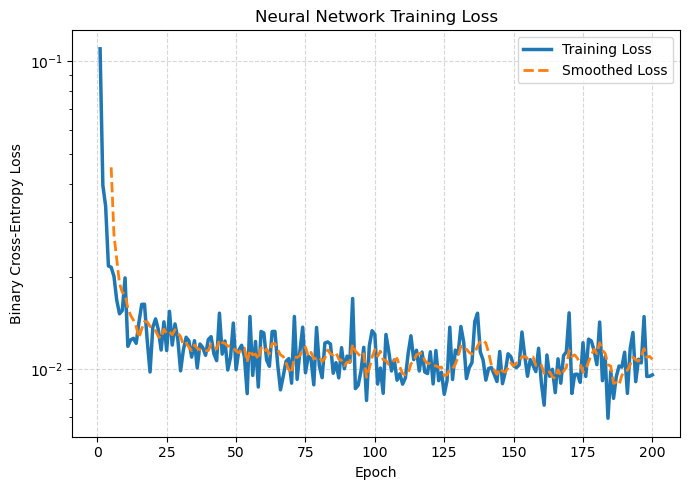

In [55]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(7, 5))
epochs = np.arange(1, max_epochs + 1)
plt.figure(figsize=(7, 5))
plt.semilogy(
    epochs,
    epoch_losses,
    lw=2.5,
    color="#1f77b4",
    label="Training Loss"
)
# Optional smoothing
window = 5
if len(epoch_losses) >= window:
    smoothed = np.convolve(epoch_losses, np.ones(window)/window, mode="valid")
    plt.semilogy(
        epochs[window-1:],
        smoothed,
        lw=2,
        linestyle="--",
        color="#ff7f0e",
        label="Smoothed Loss"
    )
plt.xlabel("Epoch")
plt.ylabel("Binary Cross-Entropy Loss")
plt.title("Neural Network Training Loss")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

In [1]:
model.eval()
with torch.no_grad():
    logits = model(X_test_tensor)
    probs = torch.sigmoid(logits)
    preds = (probs >= 0.5).long().view(-1)
    
    
acc = accuracy_score(y_test_tensor.numpy(), preds.numpy()) 
print(f"\n✅ Test Accuracy: {acc*100:.2f}%") 

cm = confusion_matrix(y_test_tensor.numpy(), preds.numpy()) 
print("\nConfusion Matrix:\n", cm) 

print("\nClassification Report:\n", classification_report(y_test_tensor.numpy(), preds.numpy()))

NameError: name 'model' is not defined

In [47]:
# ---- Manual prediction test ----
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
sample = np.array([[1., 10., 0.1]])   # mass, radius, encoded k2 (e.g., 0 for 'K2')
sample_scaled = scaler.transform(sample)

model.eval()
with torch.no_grad():
    logits = model(torch.tensor(sample_scaled, dtype=torch.float32))
    prob = torch.sigmoid(logits).item()
    pred = 1 if prob >= 0.5 else 0

print(f"\nPredicted class: {pred}  (0=Neutron, 1=Quark)")
print(f"Probability of Quark Star: {prob:.4f}")



Predicted class: 0  (0=Neutron, 1=Quark)
Probability of Quark Star: 0.0477
